Przyglądniemy się danym oraz przetworzymy je tak żeby można było na nich modelować. Chodzi głównie o dane kategoryczne na których musimy dokonać kodowania

In [1]:
# https://medium.com/databulls/tabular-playground-series-mar-2021-leaderboard-14-eda-feature-engineering-e5827982384e

# Dane zostały pobrane z poniższej lokalizacji 
# https://www.kaggle.com/c/tabular-playground-series-mar-2021/data

import pandas as pd
import numpy as np
import os

data_path = 'E:\page_ds\XGBoost_step_by_step'
data = pd.read_csv(os.path.join(data_path, "train.csv"))

train = pd.read_csv(os.path.join(data_path, "train.csv"))
test = pd.read_csv(os.path.join(data_path, "test.csv"))

train_y = train['target']
train_data = train.drop(columns=['id', 'target'])
test_data = test.drop(columns=['id'])

train_rows_len = train_data.shape[0]

train_test_data = pd.concat([train_data, test_data])

print(train_data.shape)
print(test_data.shape)
print(train_test_data.shape)

(300000, 30)
(200000, 30)
(500000, 30)


Text(0.5, 1.0, 'Histogram zmiennej celu')

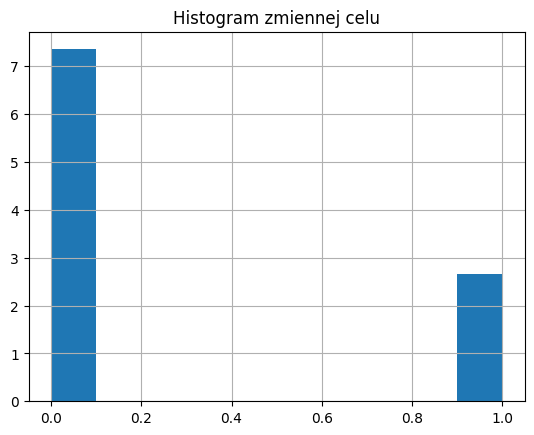

In [6]:
#wyświetlam rozkład zmiennej celu
import matplotlib.pyplot as plt
train_y.hist(density=True)  #dlaczego nie robi mi rozkładu gęstości tylko skala jest pełnoliczbowa?
plt.title("Histogram zmiennej celu")

Jak widać na podstawie powyższego wykresu, zmienna celu jest nisko niezbalansowana. Uznaje się, że zmienna celu jest nisko niezbalansowana jeżeli najrzadziej występująca wartość rozkładu będzie w przedziale 20-40%, średnio zbalansowana jeżeli będzie w przedziale 1-20%, ekstremalnie niezbalansowane gdy <1%. Jeżeli będzie w przedziale 40-50% to uznajemy rozkład za zbalansowany 

Rozdzielamy zmienne ze względu na typ (numeryczny/kategoryczne) aby następnie potraktować te zbiory osobnymi metodami

In [7]:
data_categorical_pd  = train_test_data.loc[:,train_test_data.dtypes!=np.number]
data_numerical_pd  = train_test_data.loc[:,train_test_data.dtypes==np.number]

print('data_categorical_pd.shape: ', data_categorical_pd.shape)
print('data_numerical_pd.shape: ', data_numerical_pd.shape)

data_categorical_pd.shape:  (500000, 19)
data_numerical_pd.shape:  (500000, 11)


Pozbywamy się wartości nullowych (jak się okaże, nie ma ich w zbiorze

In [8]:
#train_test_data.isnull().sum()
categorical_missing_val_count = (data_categorical_pd.isnull().sum())
numerical_missing_val_count = (data_numerical_pd.isnull().sum())
print('categorical_missing_val_count')
print(categorical_missing_val_count[categorical_missing_val_count > 0])
print('numerical_missing_val_count')
print(numerical_missing_val_count[numerical_missing_val_count > 0])

categorical_missing_val_count
Series([], dtype: int64)
numerical_missing_val_count
Series([], dtype: int64)


Wartości odstające, ale nic raczej z nimi nie zrobię

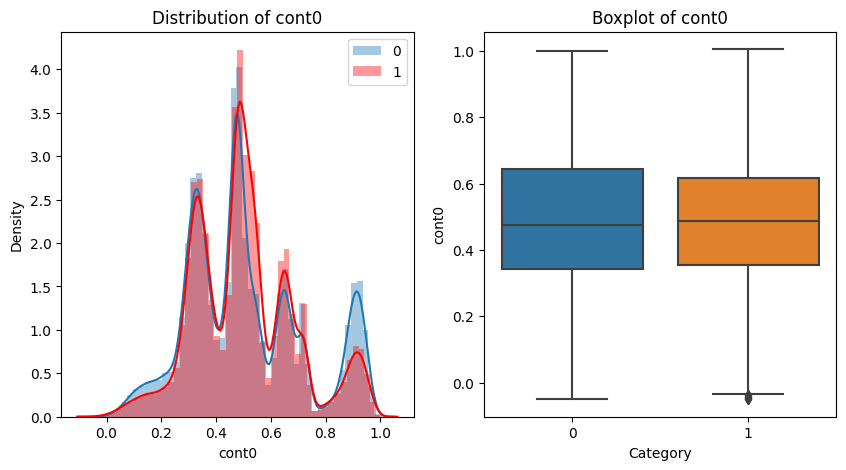

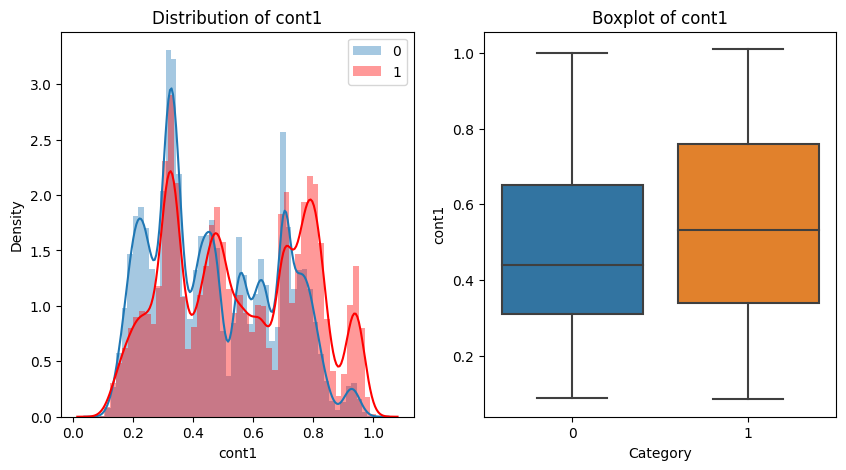

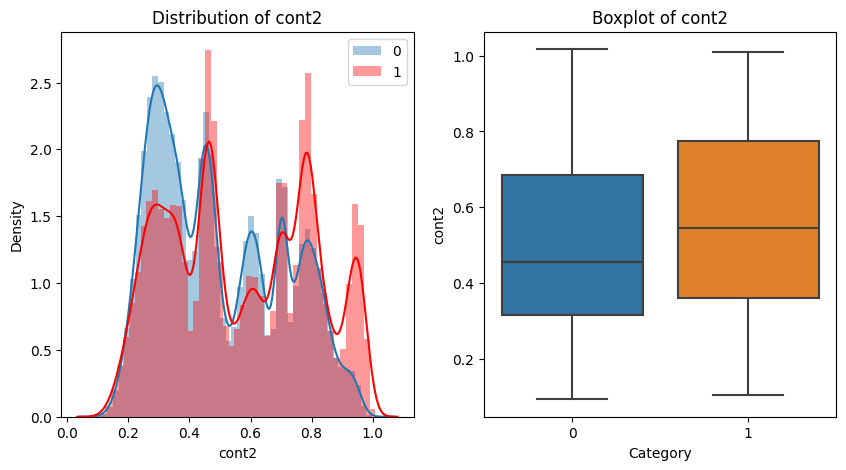

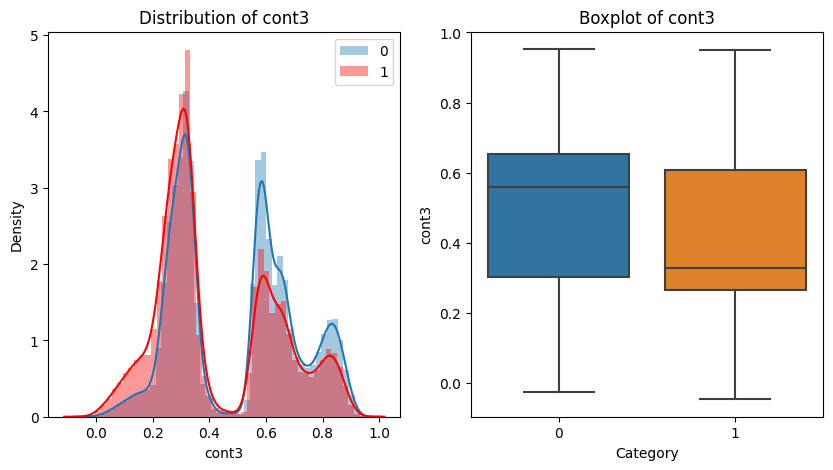

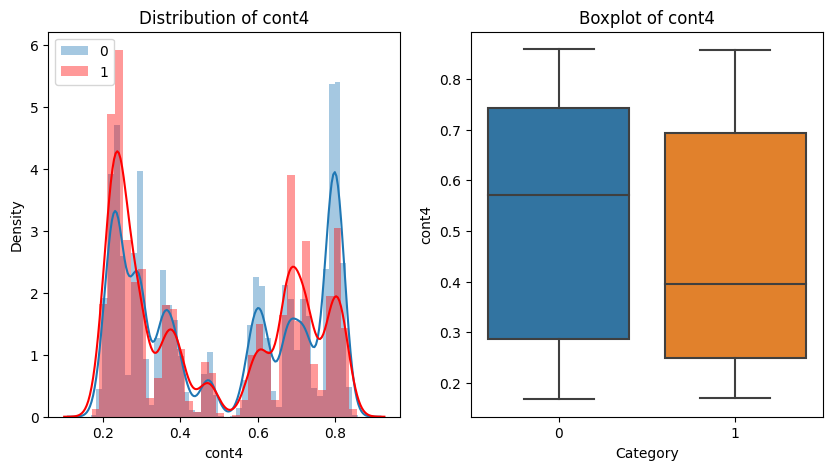

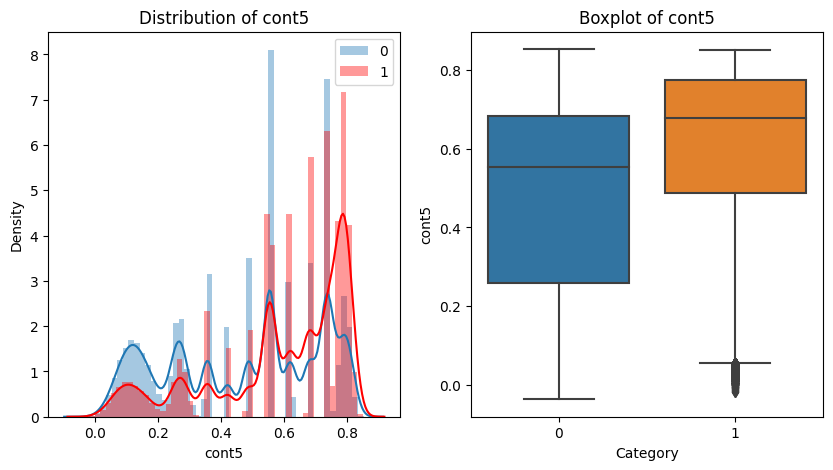

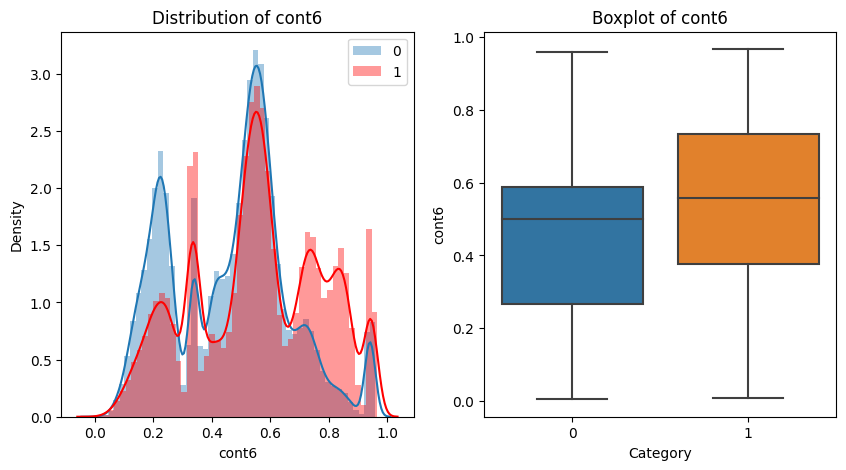

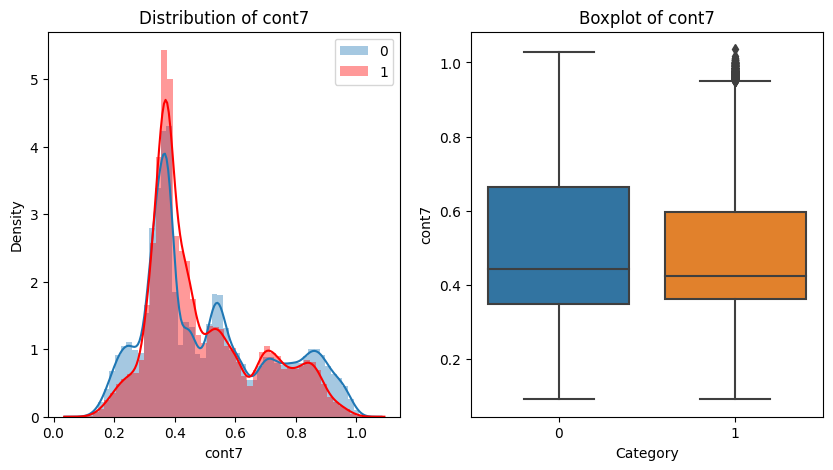

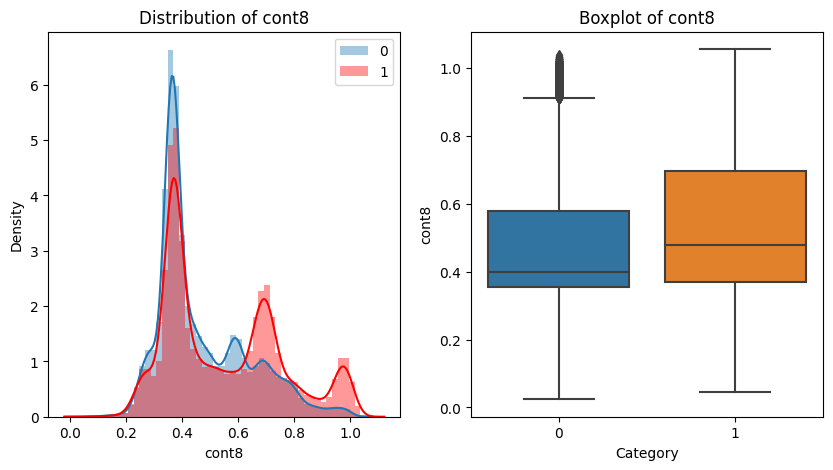

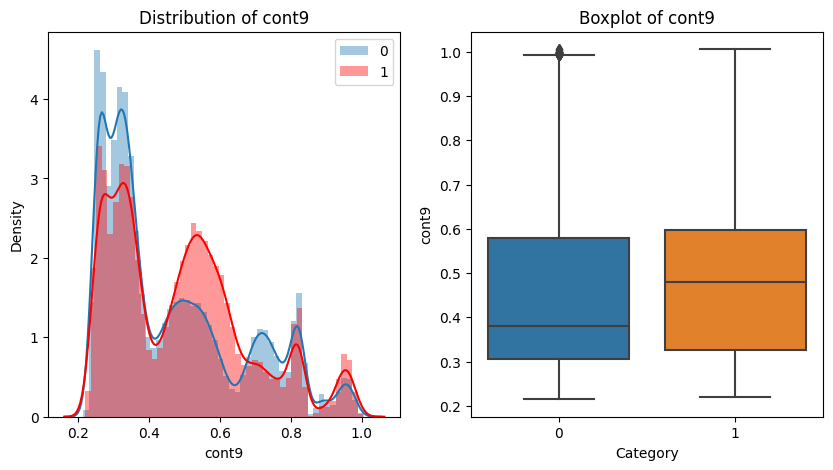

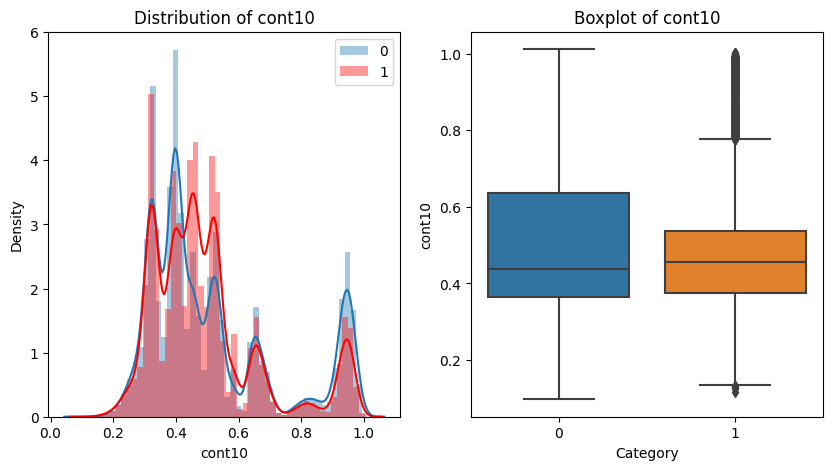

In [9]:
import seaborn as sns
import warnings
warnings.simplefilter("ignore")

# Numerical
y_plot = train_y.copy()
y_plot.columns = ['target']
Data_plot = pd.concat([data_numerical_pd[:][:len(y_plot)], y_plot], axis=1)
for feature in data_numerical_pd.columns:
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
    
    plot10 = sns.distplot(Data_plot[Data_plot['target']==0][feature],ax=ax1, label='0')
    sns.distplot(Data_plot[Data_plot['target']==1][feature],ax=ax1,color='red', label='1')
    plot10.axes.legend()
    ax1.set_title('Distribution of {name}'.format(name=feature))
    sns.boxplot(x='target',y=feature,data=Data_plot,ax=ax2)
    ax2.set_xlabel('Category') 
    ax2.set_title('Boxplot of {name}'.format(name=feature))
    fig.show()

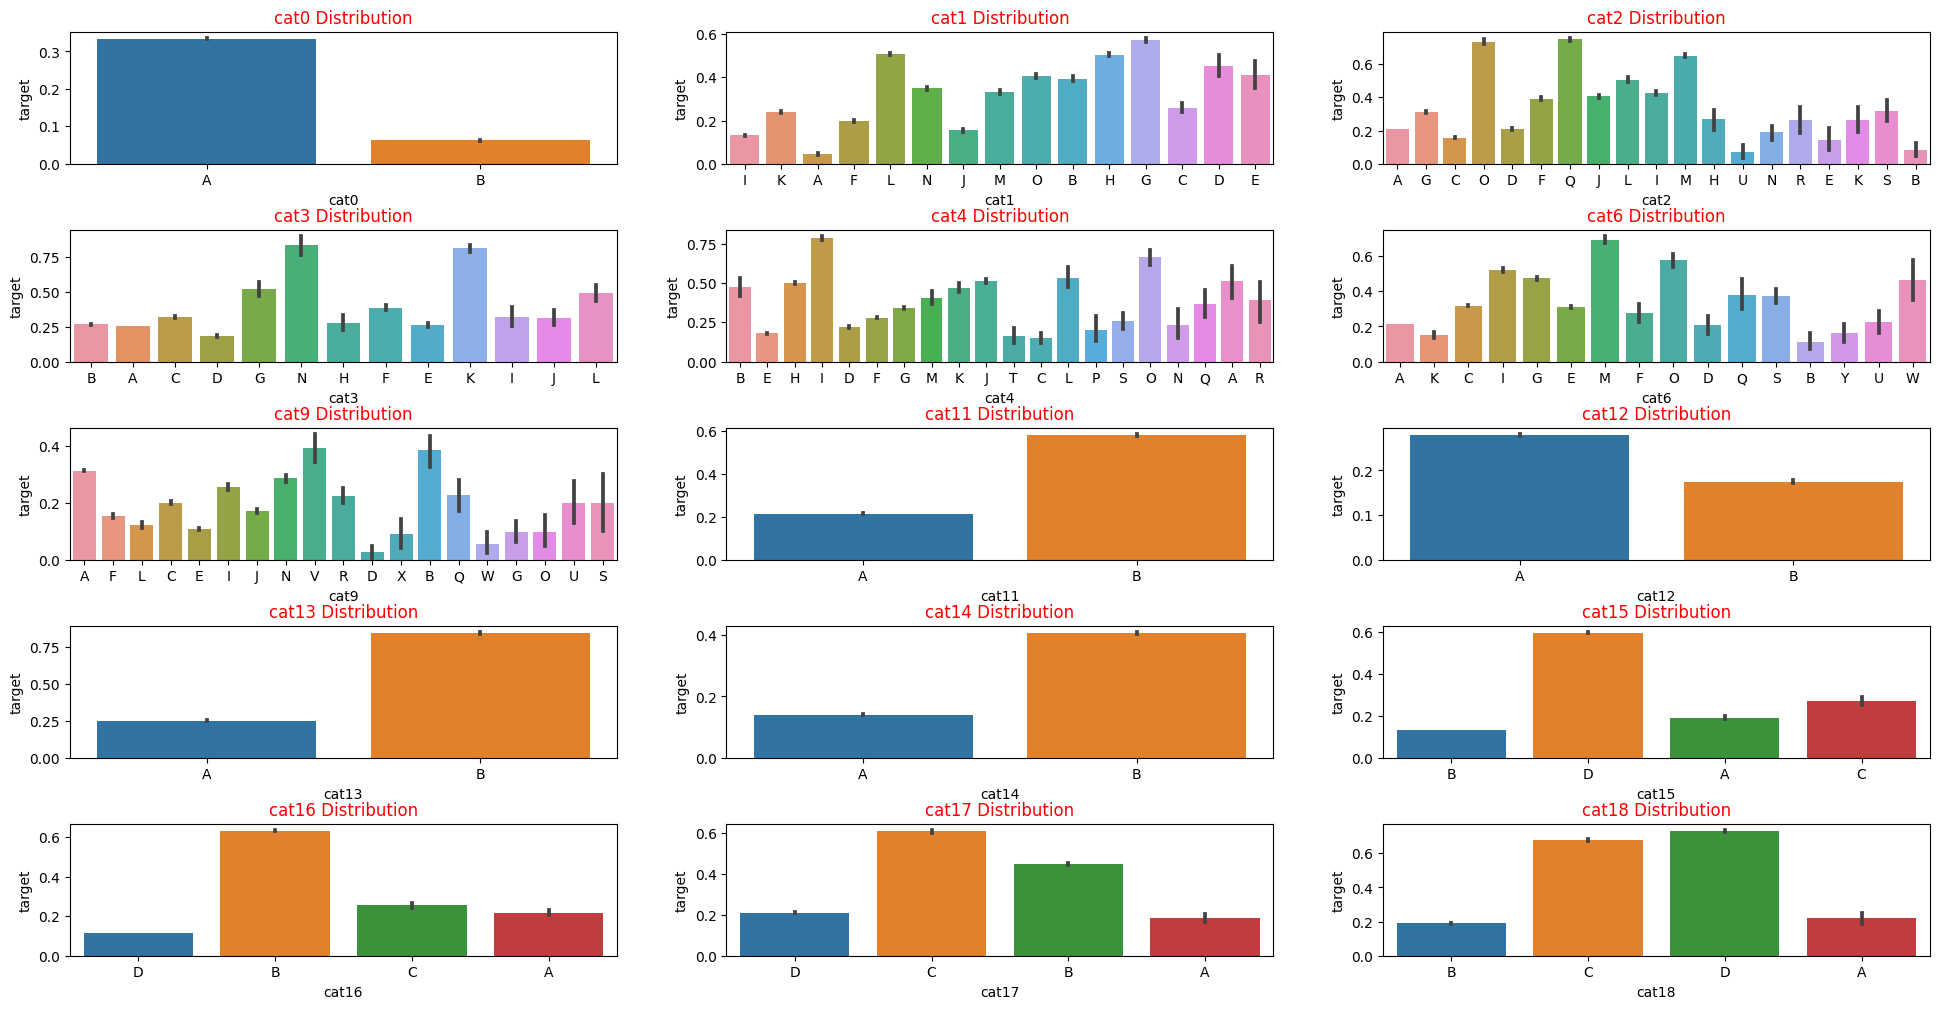

In [10]:
data_plot = pd.concat([data_categorical_pd[:][:len(y_plot)], y_plot], axis=1)
feature_list = []
for col in data_categorical_pd.columns:
    if len(data_categorical_pd[col].unique()) <= 20:
        feature_list.append(col)

n_cols = 3
nrows = round(len(feature_list) / n_cols)
fig, axes = plt.subplots(nrows, n_cols, figsize=(24, 12))
plt.subplots_adjust(hspace=0.5)

index = 0
for row in range(nrows):
    for col in range(n_cols):
        feature = feature_list[index]
        
        sns.barplot(x=feature, y='target', data=data_plot, ax=axes[row][col])
        axes[row][col].set_title(feature + ' Distribution', color = 'red')
        
        index += 1
plt.show()

Kilka zmiennych odpadło na warunku liczby różnych wartości dla zmiennej kategoryzcnych z czego najwięcej różnych wartości przyjmuje zmienna Cat10, jest to kiepska zmienna dla modeli ML. Można ją wywalić albo pogrupować rzadko występujące wartości (np. Others)

In [34]:
from sklearn.model_selection import train_test_split

object_cols = data_categorical_pd.columns
X_train, X_valid, y_train, y_valid = train_test_split(data_categorical_pd[:][:len(train_y)], train_y, train_size=0.8, test_size=0.2,
                                                      random_state=0)

# Columns that can be safely label encoded
good_label_cols = [col for col in object_cols if 
                   set(X_train[col]) == set(X_valid[col])]
        
# Problematic columns that will be dropped from the dataset
bad_label_cols = list(set(object_cols)-set(good_label_cols))

print('good_label_cols: ', len(good_label_cols))
print(good_label_cols)
print('bad_label_cols: ', len(bad_label_cols))
print(bad_label_cols)
good_label_cols:  18
['cat0', 'cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6', 'cat7', 'cat8', 'cat9', 'cat11', 'cat12', 'cat13', 'cat14', 'cat15', 'cat16', 'cat17', 'cat18']
bad_label_cols:  1
['cat10']

good_label_cols:  18
['cat0', 'cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6', 'cat7', 'cat8', 'cat9', 'cat11', 'cat12', 'cat13', 'cat14', 'cat15', 'cat16', 'cat17', 'cat18']
bad_label_cols:  1
['cat10']


['cat10']

In [39]:
th = 100

cat10_counts = data_categorical_pd['cat10'].value_counts()
cat10_cut_values = cat10_counts[cat10_counts > th].index
print('cat10_cut_values: ', len(cat10_cut_values))

cat10_cut_values_list = []
for value in data_categorical_pd['cat10']:
    if value in cat10_cut_values:
        cat10_cut_values_list.append(value)
    else:
        cat10_cut_values_list.append('others')

data_categorical_temp_pd = data_categorical_pd.copy()
data_categorical_temp_pd['cat10'] = cat10_cut_values_list

object_cols = data_categorical_temp_pd.columns
X_train, X_valid, y_train, y_valid = train_test_split(data_categorical_temp_pd[:][:len(train_y)], train_y, train_size=0.8, test_size=0.2,
                                                      random_state=0)

print('cat10: ', set(X_train['cat10']) == set(X_valid['cat10']))

cat10_cut_values:  186
cat10:  True


Dekodowanie - Model ML nie potrafi się uczyć na zmiennych o dużych wartościach. Dlatego przeprowadzimy kodowanie za pomocą bliblioteki OneHotEncoding


In [40]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

data_categorical_encoded_pd = data_categorical_temp_pd.copy()
for feature in data_categorical_encoded_pd.columns:
        le = LabelEncoder()
        data_categorical_encoded_pd[feature] = le.fit_transform(data_categorical_temp_pd[feature].astype(str))
        
print(data_categorical_encoded_pd.info())
print(data_numerical_pd.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 500000 entries, 0 to 199999
Data columns (total 19 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   cat0    500000 non-null  int32
 1   cat1    500000 non-null  int32
 2   cat2    500000 non-null  int32
 3   cat3    500000 non-null  int32
 4   cat4    500000 non-null  int32
 5   cat5    500000 non-null  int32
 6   cat6    500000 non-null  int32
 7   cat7    500000 non-null  int32
 8   cat8    500000 non-null  int32
 9   cat9    500000 non-null  int32
 10  cat10   500000 non-null  int32
 11  cat11   500000 non-null  int32
 12  cat12   500000 non-null  int32
 13  cat13   500000 non-null  int32
 14  cat14   500000 non-null  int32
 15  cat15   500000 non-null  int32
 16  cat16   500000 non-null  int32
 17  cat17   500000 non-null  int32
 18  cat18   500000 non-null  int32
dtypes: int32(19)
memory usage: 40.1 MB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 500000 entries, 0 to 199999
Data colum

In [41]:
for feature in data_categorical_encoded_pd.columns:
    value = len(data_categorical_encoded_pd[feature].unique())
    print(feature, value)

same_len_19 = ['cat9', 'cat2']
same_len_4 = ['cat15', 'cat16', 'cat17', 'cat18']
same_len_2 = ['cat0', 'cat11', 'cat12', 'cat13', 'cat14']

cat0 2
cat1 15
cat2 19
cat3 13
cat4 20
cat5 84
cat6 16
cat7 51
cat8 61
cat9 19
cat10 187
cat11 2
cat12 2
cat13 2
cat14 2
cat15 4
cat16 4
cat17 4
cat18 4


In [42]:
data_categorical_FeaEng_pd = data_categorical_encoded_pd.copy()
data_numerical_FeaEng_pd = data_numerical_pd.copy()

data_categorical_FeaEng_pd['cat9cat2T'] = data_categorical_encoded_pd['cat9'] + data_categorical_encoded_pd['cat2']
data_categorical_FeaEng_pd['cat9cat2M'] = data_categorical_encoded_pd['cat9'] * data_categorical_encoded_pd['cat2']

data_categorical_FeaEng_pd['cat15cat16T'] = data_categorical_encoded_pd['cat15'] + data_categorical_encoded_pd['cat16']
data_categorical_FeaEng_pd['cat15cat17T'] = data_categorical_encoded_pd['cat15'] + data_categorical_encoded_pd['cat17']
data_categorical_FeaEng_pd['cat15cat18T'] = data_categorical_encoded_pd['cat15'] + data_categorical_encoded_pd['cat18']
data_categorical_FeaEng_pd['cat16cat17T'] = data_categorical_encoded_pd['cat16'] + data_categorical_encoded_pd['cat17']
data_categorical_FeaEng_pd['cat16cat18T'] = data_categorical_encoded_pd['cat16'] + data_categorical_encoded_pd['cat18']
data_categorical_FeaEng_pd['cat17cat18T'] = data_categorical_encoded_pd['cat17'] + data_categorical_encoded_pd['cat18']
data_categorical_FeaEng_pd['cat15cat16M'] = data_categorical_encoded_pd['cat15'] * data_categorical_encoded_pd['cat16']
data_categorical_FeaEng_pd['cat15cat17M'] = data_categorical_encoded_pd['cat15'] * data_categorical_encoded_pd['cat17']
data_categorical_FeaEng_pd['cat15cat18M'] = data_categorical_encoded_pd['cat15'] * data_categorical_encoded_pd['cat18']
data_categorical_FeaEng_pd['cat16cat17M'] = data_categorical_encoded_pd['cat16'] * data_categorical_encoded_pd['cat17']
data_categorical_FeaEng_pd['cat16cat18M'] = data_categorical_encoded_pd['cat16'] * data_categorical_encoded_pd['cat18']
data_categorical_FeaEng_pd['cat17cat18M'] = data_categorical_encoded_pd['cat17'] * data_categorical_encoded_pd['cat18']

data_categorical_FeaEng_pd['cat0cat11T'] = data_categorical_encoded_pd['cat0'] + data_categorical_encoded_pd['cat11']
data_categorical_FeaEng_pd['cat0cat12T'] = data_categorical_encoded_pd['cat0'] + data_categorical_encoded_pd['cat12']
data_categorical_FeaEng_pd['cat0cat13T'] = data_categorical_encoded_pd['cat0'] + data_categorical_encoded_pd['cat13']
data_categorical_FeaEng_pd['cat0cat14T'] = data_categorical_encoded_pd['cat0'] + data_categorical_encoded_pd['cat14']
data_categorical_FeaEng_pd['cat11cat12T'] = data_categorical_encoded_pd['cat11'] + data_categorical_encoded_pd['cat12']
data_categorical_FeaEng_pd['cat11cat13T'] = data_categorical_encoded_pd['cat11'] + data_categorical_encoded_pd['cat13']
data_categorical_FeaEng_pd['cat11cat14T'] = data_categorical_encoded_pd['cat11'] + data_categorical_encoded_pd['cat14']
data_categorical_FeaEng_pd['cat12cat13T'] = data_categorical_encoded_pd['cat12'] + data_categorical_encoded_pd['cat13']
data_categorical_FeaEng_pd['cat12cat14T'] = data_categorical_encoded_pd['cat12'] + data_categorical_encoded_pd['cat14']
data_categorical_FeaEng_pd['cat13cat14T'] = data_categorical_encoded_pd['cat13'] + data_categorical_encoded_pd['cat14']
data_categorical_FeaEng_pd['cat0cat11M'] = data_categorical_encoded_pd['cat0'] * data_categorical_encoded_pd['cat11']
data_categorical_FeaEng_pd['cat0cat12M'] = data_categorical_encoded_pd['cat0'] * data_categorical_encoded_pd['cat12']
data_categorical_FeaEng_pd['cat0cat13M'] = data_categorical_encoded_pd['cat0'] * data_categorical_encoded_pd['cat13']
data_categorical_FeaEng_pd['cat0cat14M'] = data_categorical_encoded_pd['cat0'] * data_categorical_encoded_pd['cat14']
data_categorical_FeaEng_pd['cat11cat12M'] = data_categorical_encoded_pd['cat11'] * data_categorical_encoded_pd['cat12']
data_categorical_FeaEng_pd['cat11cat13M'] = data_categorical_encoded_pd['cat11'] * data_categorical_encoded_pd['cat13']
data_categorical_FeaEng_pd['cat11cat14M'] = data_categorical_encoded_pd['cat11'] * data_categorical_encoded_pd['cat14']
data_categorical_FeaEng_pd['cat12cat13M'] = data_categorical_encoded_pd['cat12'] * data_categorical_encoded_pd['cat13']
data_categorical_FeaEng_pd['cat12cat14M'] = data_categorical_encoded_pd['cat12'] * data_categorical_encoded_pd['cat14']
data_categorical_FeaEng_pd['cat13cat14M'] = data_categorical_encoded_pd['cat13'] * data_categorical_encoded_pd['cat14']

In [43]:
data_categorical_FeaEng_pd['cat15_16TotalTotal'] = (data_categorical_FeaEng_pd['cat15cat16T'] + data_categorical_FeaEng_pd['cat15cat17T'] +
                                                    data_categorical_FeaEng_pd['cat15cat18T'] + data_categorical_FeaEng_pd['cat16cat17T'] + 
                                                    data_categorical_FeaEng_pd['cat16cat18T'] + data_categorical_FeaEng_pd['cat17cat18T'])
data_categorical_FeaEng_pd['cat15_16MulTotal'] = (data_categorical_FeaEng_pd['cat15cat16M'] + data_categorical_FeaEng_pd['cat15cat17M'] +
                                                    data_categorical_FeaEng_pd['cat15cat18M'] + data_categorical_FeaEng_pd['cat16cat17M'] + 
                                                    data_categorical_FeaEng_pd['cat16cat18M'] + data_categorical_FeaEng_pd['cat17cat18M'])

data_categorical_FeaEng_pd['cat11_14TotalTotal'] = (data_categorical_FeaEng_pd['cat0cat11T'] + data_categorical_FeaEng_pd['cat0cat12T'] +
                                                   data_categorical_FeaEng_pd['cat0cat13T'] + data_categorical_FeaEng_pd['cat0cat14T'] +
                                                   data_categorical_FeaEng_pd['cat11cat12T'] + data_categorical_FeaEng_pd['cat11cat13T'] +
                                                   data_categorical_FeaEng_pd['cat11cat14T'] + data_categorical_FeaEng_pd['cat12cat13T'] +
                                                   data_categorical_FeaEng_pd['cat12cat14T'] + data_categorical_FeaEng_pd['cat13cat14T'])
data_categorical_FeaEng_pd['cat11_14MulTotal'] = (data_categorical_FeaEng_pd['cat0cat11M'] + data_categorical_FeaEng_pd['cat0cat12M'] +
                                                   data_categorical_FeaEng_pd['cat0cat13M'] + data_categorical_FeaEng_pd['cat0cat14M'] +
                                                   data_categorical_FeaEng_pd['cat11cat12M'] + data_categorical_FeaEng_pd['cat11cat13M'] +
                                                   data_categorical_FeaEng_pd['cat11cat14M'] + data_categorical_FeaEng_pd['cat12cat13M'] +
                                                   data_categorical_FeaEng_pd['cat12cat14M'] + data_categorical_FeaEng_pd['cat13cat14M'])

Transformujemy zmienne 

In [44]:
from sklearn import preprocessing

data_numerical_norm_pd = data_numerical_FeaEng_pd.copy()
data_categorical_norm_pd = data_categorical_FeaEng_pd.copy()

for index, feature in enumerate(data_numerical_FeaEng_pd.columns):
    min_max_scaler = preprocessing.MinMaxScaler()
    
    norm_list = min_max_scaler.fit_transform(
        data_numerical_FeaEng_pd[data_numerical_FeaEng_pd.columns[index:index+1]])
    
    data_numerical_norm_pd[feature] = norm_list + 1

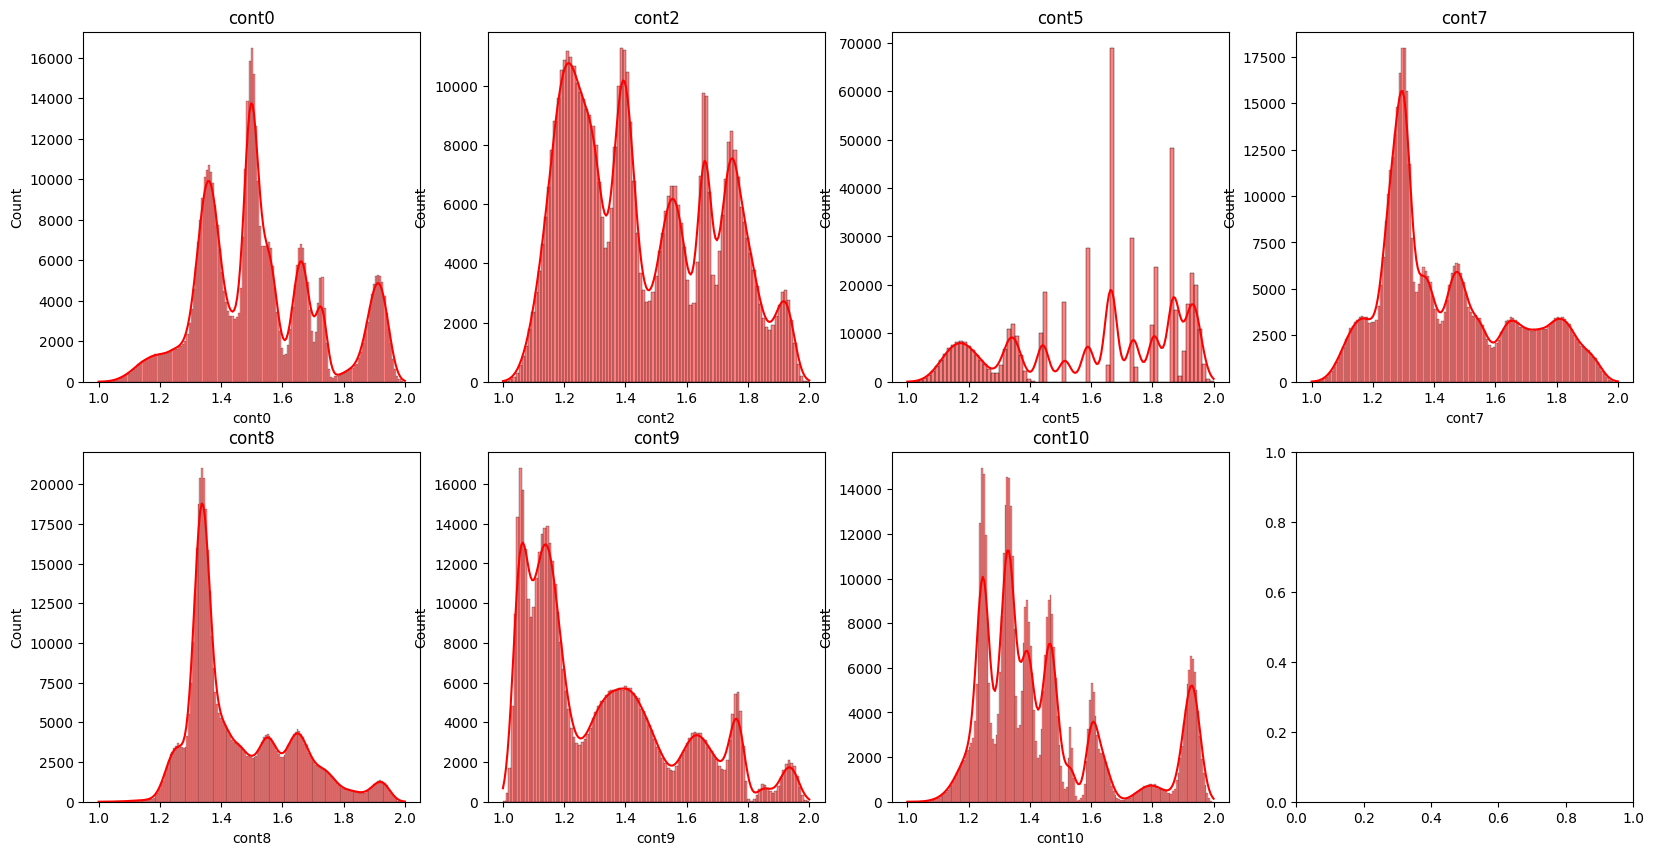

In [45]:
from scipy.stats import skew, boxcox
import seaborn as sns

data_numerical_TR_pd = data_numerical_norm_pd.copy()
data_categorical_TR_pd = data_categorical_norm_pd.copy()

skew_feature_list = []
for feature in data_numerical_norm_pd.columns:
    skew_value = skew(data_numerical_norm_pd[feature])
    if abs(skew_value) > 0.3:
        _, fitted_lambda = boxcox(data_numerical_norm_pd[feature])
        data_numerical_TR_pd[feature] = data_numerical_norm_pd[feature] ** fitted_lambda
        skew_feature_list.append(feature)
        
n_rows = round(data_numerical_TR_pd.shape[1] / 4)
n_rows = n_rows - 1
fig, axs = plt.subplots(nrows=n_rows, ncols=4, figsize=(20, 10))
index = 0
for i in range(n_rows):
    for j in range(4):
        try:
            sns.histplot(data_numerical_norm_pd[skew_feature_list[index]], kde = True, color = 'red', stat = 'count', ax=axs[i][j])
            axs[i][j].title.set_text(skew_feature_list[index])
        except:
            break
        index = index + 1
plt.show()


In [46]:
X_train = pd.concat([data_numerical_TR_pd[:][:train_rows_len], data_categorical_TR_pd[:][:train_rows_len]], axis=1)
X_test = pd.concat([data_numerical_TR_pd[:][train_rows_len:], data_categorical_TR_pd[:][train_rows_len:]], axis=1)
y_train = train_y.copy()

X_train.to_csv(os.path.join(data_path, 'x_train.csv'),index=False)
X_test.to_csv(os.path.join(data_path, 'x_test.csv') ,index=False)
y_train.to_csv(os.path.join(data_path, 'y_train.csv') ,index=False)

print('X_train shape: ', X_train.shape)
print('X_test shape: ', X_test.shape)
print('y_train shape: ', y_train.shape)
print(X_train.head())

X_train shape:  (300000, 68)
X_test shape:  (200000, 68)
y_train shape:  (300000,)
      cont0     cont1     cont2     cont3     cont4     cont5     cont6  \
0  0.771882  1.831469  0.757355  1.831778  1.734982  3.604858  1.614927   
1  0.839769  1.263666  0.868692  1.580342  1.315982  2.338179  1.623011   
2  0.803225  1.257000  0.884926  1.654517  1.894852  3.244596  1.367991   
3  0.709523  1.672173  0.740416  1.843903  1.903929  3.591256  1.233940   
4  0.876465  1.204973  0.886647  1.319137  1.632942  1.481867  1.601123   

      cont7     cont8     cont9  ...  cat11cat12M  cat11cat13M  cat11cat14M  \
0  0.417356  0.158744  0.256644  ...            0            0            0   
1  0.633500  0.362071  0.269906  ...            0            0            0   
2  0.649517  0.351679  0.825885  ...            0            0            0   
3  0.378396  0.221788  0.343216  ...            0            0            0   
4  0.751206  0.404528  0.713877  ...            0            0         